# Neural Style transfer con VGG-16 y TensorFlow


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import scipy.misc
import tensorflow as tf
import os
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

STYLE_IMAGE = 'images/seated-nude500.jpg'
# Content image to use.
CONTENT_IMAGE = 'images/dani500.jpg'
OUTPUT_DIR = 'output/'
# Image dimensions constants.
IMAGE_WIDTH = 500
IMAGE_HEIGHT = 621
COLOR_CHANNELS = 3
NOISE_RATIO = 0.1
ALPHA = 10 #content importance
BETA = 100 #style importance
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
LAYER_WEIGHTS = {
    'conv1_1': 0.2,
    'conv2_1': 0.2,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

De acuerdo a Gatys et al, el content loss usa el mean squared error entre las representaciones (feature maps) de la capa `conv4_2` para la imagen generada $F$ y la imagen original $P$. En una capa $l$ cualquiera, el content loss es definido como :

$$\mathcal{L}_{\mathsf{content}}(\vec{p},\vec{x}, l) = \frac12 \sum_{i,j} (F_{ij}^l - P_{ij}^l)^2$$

In [77]:
def get_content_loss(content_features, generated_features):
    n, h, w, c = generated_features.get_shape().as_list()
    return tf.reduce_sum(tf.square(tf.subtract(content_features, generated_features)))/(4*h*w*c)

Por otro lado, Gatys et al proponen calcular la correlación entre los feature maps de una capa determinada como una medida de _estilo_. La lógica detrás de esto es que el cálculo de la matriz de correlación (Gram Matrix) desecha la información de alto nivel relacionada con el contenido de la imagen, pero conserva la relacionada con la información de bajo nivel (activación de los pixeles). Entre más profunda la capa, más _estilo_ es capturado por la matriz de correlación. De acuerdo a esto, definen el style loss en una capa cualquiera $l$ como:

$$E_l = \frac{1}{4N_l^2M_l^2}\sum_{i,j} (G_{ij}^l - A_{ij}^l)^2 $$

donde $G^l = F^{l^T}F^l$, es la Gram Matrix (matriz de correlación). Cada elemento $G_{ij}^l$ representa el producto escalar entre el (flattened) feature map $i$ y el feature map $j$ de la capa $l$. De manera análoga, $A^l$ es la Gram Matrix correspondiente a la imagen original.

De acuerdo a Gatys et al, para aproximar mejor el estilo de una imagen es conveniente incorporar información de multiples capas. Por esto, definen el total style loss como:

$$\mathcal{L}_{\mathsf{style}}(\vec{a},\vec{x}) = \sum_{l=0}^L w_lE_l$$

donde los $w_l$ son coeficientes que representan la importancia de la información de estilo proveniente de cada capa. Definamos en Python el style loss:

In [78]:
def gram_matrix(matrix):
    return tf.matmul(matrix, tf.transpose(matrix))


def get_layer_style_loss(a, g):
    n, h, w, c = g.get_shape().as_list()
    a = tf.reshape(tf.transpose(a[0], perm=[2,0,1]), [c, h*w])
    g = tf.reshape(tf.transpose(g[0], perm=[2,0,1]), [c, h*w])
    return tf.reduce_sum(tf.square(tf.subtract(gram_matrix(g), gram_matrix(a))))/(4 * (c)**2 * (h*w)**2)


def get_total_style_loss(model):
    total_style_cost = 0
    for n, w in LAYER_WEIGHTS.items():
        total_style_cost += w * get_layer_style_loss(sess.run(model[n]), model[n])
    return total_style_cost

Procedemos a construir el grafo computacional de la red. Conseguí la estructura y pesos de la red VGG para TensorFlow en [VGG in TensorFlow](https://www.cs.toronto.edu/~frossard/post/vgg16/).

In [79]:
def model(weights):
    
    model = {}
    img = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    model['img'] = img
    # conv1_1
    with tf.name_scope('conv1_1') as scope:
        kernel = tf.constant(weights['conv1_1_W'])
        conv = tf.nn.conv2d(img, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv1_1_b'])
        out = tf.nn.bias_add(conv, biases)
        conv1_1 = tf.nn.relu(out, name=scope)
        model['conv1_1'] = conv1_1
    
    # conv1_2
    with tf.name_scope('conv1_2') as scope:
        kernel = tf.constant(weights['conv1_2_W'])
        conv = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv1_2_b'])
        out = tf.nn.bias_add(conv, biases)
        conv1_2 = tf.nn.relu(out, name=scope)
        model['conv1_2'] = conv1_2
    
    # pool1
    pool1 = tf.nn.avg_pool(conv1_2,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME',
                           name='pool1')
    model['pool1'] = pool1
    
    # conv2_1
    with tf.name_scope('conv2_1') as scope:
        kernel = tf.constant(weights['conv2_1_W'])
        conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv2_1_b'])
        out = tf.nn.bias_add(conv, biases)
        conv2_1 = tf.nn.relu(out, name=scope)
        model['conv2_1'] = conv2_1
    
    # conv2_2
    with tf.name_scope('conv2_2') as scope:
        kernel = tf.constant(weights['conv2_2_W'])
        conv = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv2_2_b'])
        out = tf.nn.bias_add(conv, biases)
        conv2_2 = tf.nn.relu(out, name=scope)
        model['conv2_2'] = conv2_2
    
    # pool2
    pool2 = tf.nn.avg_pool(conv2_2,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME',
                           name='pool2')
    model['pool2'] = pool2
    
    # conv3_1
    with tf.name_scope('conv3_1') as scope:
        kernel = tf.constant(weights['conv3_1_W'])
        conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv3_1_b'])
        out = tf.nn.bias_add(conv, biases)
        conv3_1 = tf.nn.relu(out, name=scope)
        model['conv3_1'] = conv3_1
    
    # conv3_2
    with tf.name_scope('conv3_2') as scope:
        kernel = tf.constant(weights['conv3_2_W'])
        conv = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv3_2_b'])
        out = tf.nn.bias_add(conv, biases)
        conv3_2 = tf.nn.relu(out, name=scope)
        model['conv3_2'] = conv3_2
    
    # conv3_3
    with tf.name_scope('conv3_3') as scope:
        kernel = tf.constant(weights['conv3_3_W'])
        conv = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv3_3_b'])
        out = tf.nn.bias_add(conv, biases)
        conv3_3 = tf.nn.relu(out, name=scope)
        model['conv3_3'] = conv3_3
    
    # pool3
    pool3 = tf.nn.avg_pool(conv3_3,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME',
                           name='pool3')
    model['pool3'] = pool3
    
    # conv4_1
    with tf.name_scope('conv4_1') as scope:
        kernel = tf.constant(weights['conv4_1_W'])
        conv = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv4_1_b'])
        out = tf.nn.bias_add(conv, biases)
        conv4_1 = tf.nn.relu(out, name=scope)
        model['conv4_1'] = conv4_1
    
    # conv4_2
    with tf.name_scope('conv4_2') as scope:
        kernel = tf.constant(weights['conv4_2_W'])
        conv = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv4_2_b'])
        out = tf.nn.bias_add(conv, biases)
        conv4_2 = tf.nn.relu(out, name=scope)
        model['conv4_2'] = conv4_2
    
    # conv4_3
    with tf.name_scope('conv4_3') as scope:
        kernel = tf.constant(weights['conv4_3_W'])
        conv = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv4_3_b'])
        out = tf.nn.bias_add(conv, biases)
        conv4_3 = tf.nn.relu(out, name=scope)
        model['conv4_3'] = conv4_3
    
    # pool4
    pool4 = tf.nn.avg_pool(conv4_3,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME',
                           name='pool4')
    model['pool4'] = pool4
    
    # conv5_1
    with tf.name_scope('conv5_1') as scope:
        kernel = tf.constant(weights['conv5_1_W'])
        conv = tf.nn.conv2d(pool4, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv5_1_b'])
        out = tf.nn.bias_add(conv, biases)
        conv5_1 = tf.nn.relu(out, name=scope)
        model['conv5_1'] = conv5_1
    
    # conv5_2
    '''with tf.name_scope('conv5_2') as scope:
        kernel = tf.constant(weights['conv5_2_W'])
        conv = tf.nn.conv2d(conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv5_2_b'])
        out = tf.nn.bias_add(conv, biases)
        conv5_2 = tf.nn.relu(out, name=scope)
        model['conv5_2'] = conv5_2
    
    # conv5_3
    with tf.name_scope('conv5_3') as scope:
        kernel = tf.constant(weights['conv5_3_W'])
        conv = tf.nn.conv2d(conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.constant(weights['conv5_3_b'])
        out = tf.nn.bias_add(conv, biases)
        conv5_3 = tf.nn.relu(out, name=scope)
        model['conv5_3'] = conv5_3
    
    # pool5
    pool5 = tf.nn.max_pool(conv5_3,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME',
                           name='pool4')
    model['pool5'] = pool5'''
    return model

In [80]:
def load_image(path):
    image = scipy.misc.imread(path)
    image = np.reshape(image, ((1,) + image.shape))
    return image

def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(
            -20, 20,
            (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image


def save_image(path, image):
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

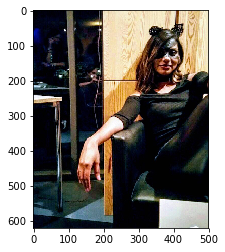

In [81]:
content_image = load_image(CONTENT_IMAGE)
style_image = load_image(STYLE_IMAGE)
generated_image = generate_noise_image(content_image)
plt.imshow(content_image[0])

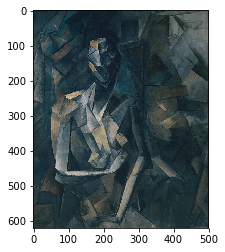

In [82]:
plt.imshow(style_image[0])

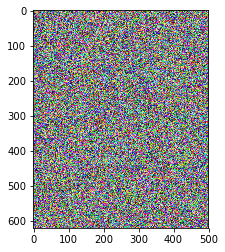

In [83]:
plt.imshow(generated_image[0])

In [84]:
#Load pretrained weights
conv_weights = np.load('vgg16_conv_weights.npz')
#Load VGG 
vgg = model(conv_weights)
sess = tf.InteractiveSession()

#load content image and compute content image content features
sess.run(vgg['img'].assign(content_image - MEAN_VALUES))
content_features = sess.run(vgg['conv4_2'])

#create content loss tensor
content_loss = get_content_loss(content_features, vgg['conv4_2'])

#load style image
sess.run(vgg['img'].assign(style_image - MEAN_VALUES))

#create style loss tensor
style_loss = get_total_style_loss(vgg)



#create total loss tensor
total_loss = ALPHA*content_loss + BETA*style_loss

#create optimizer
optimizer = tf.train.AdamOptimizer(2.0)
train_op = optimizer.minimize(total_loss)
tf.global_variables_initializer().run()

sess.run(tf.global_variables_initializer())

#assign initial generated image
sess.run(vgg['img'].assign(generated_image - MEAN_VALUES))

for i in range(200):
    sess.run(train_op)
    res = sess.run(vgg['img'])
    if i % 20 == 0:
        cost = sess.run(total_loss)
        print("Iteration: {0}, cost: {1}".format(i, cost))
        if not os.path.exists(OUTPUT_DIR):
            os.mkdir(OUTPUT_DIR)

        filename = 'output/%d.png' % (i)
        save_image(filename, res)

Iteration: 0, cost: 3645541632.0
Iteration: 20, cost: 364662656.0
Iteration: 40, cost: 106407272.0
Iteration: 60, cost: 44902568.0
Iteration: 80, cost: 25494090.0
Iteration: 100, cost: 16917810.0
Iteration: 120, cost: 12245661.0
Iteration: 140, cost: 9361463.0
Iteration: 160, cost: 7444658.5
Iteration: 180, cost: 6100616.5


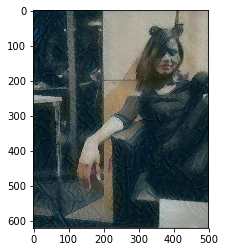

In [85]:
save_image('output/art.jpg', res)
plt.imshow(load_image('output/art.jpg')[0])
sess.close()